link to sheets: https://docs.google.com/spreadsheets/d/1fxqO1YTm68c_4OVL3glYpUaMGJpW52t1vjyQd8L0ApM/edit?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Jun 16 17:17:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

WANT Tesla T4 or Tesla P100

AVOID k80

# Model 1

In [ ]:
!pip install -Uq tensorflow==2.4

     |████████████████████████████████| 394.7MB 43kB/s 
     |████████████████████████████████| 471kB 46.5MB/s 
     |████████████████████████████████| 2.9MB 44.6MB/s 
     |████████████████████████████████| 3.8MB 41.1MB/s 


In [ ]:
!unzip -q /content/drive/MyDrive/dataset2.zip # change the filepath to the dataset

In [ ]:
import os
import random
import shutil
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet201 # insert the model name that will be used from https://keras.io/api/applications/
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard,LearningRateScheduler
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32 # change batch size accordingly
EPOCHS = 50
LEARNING_RATE = 1e-4 # change learning rate accordingly
NUM_CLASSES = 2
SPLIT = 0.2
SEED = 42

In [ ]:
random.seed(SEED)
os.chdir('/content/dataset')
if os.path.isdir('/content/train/covid') is False:
    os.makedirs('/content/train/covid')
    os.makedirs('/content/train/normal')
    os.makedirs('/content/val/covid')
    os.makedirs('/content/val/normal')
    os.makedirs('/content/test/covid')
    os.makedirs('/content/test/normal')

    for c in random.sample(glob.glob('COVID*'), 2892):
        shutil.move(c, '/content/train/covid')
    for c in random.sample(glob.glob('COVID*'), 362):
        shutil.move(c, '/content/val/covid')
    for c in random.sample(glob.glob('COVID*'), 362):
        shutil.move(c, '/content/test/covid')
    for c in random.sample(glob.glob('Normal*'), 8154):
        shutil.move(c, '/content/train/normal')
    for c in random.sample(glob.glob('Normal*'), 1019):
        shutil.move(c, '/content/val/normal')
    for c in random.sample(glob.glob('Normal*'), 1019):
        shutil.move(c, '/content/test/normal')

os.chdir('../')


In [ ]:
train_path = '/content/train'
val_path = '/content/val'
test_path = '/content/test'

In [ ]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 10,
    horizontal_flip = True)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    shuffle=True)

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    shuffle=True)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    shuffle=False)

Found 11046 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.


In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False) # insert model name

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
model_1 = Sequential()
model_1.add(base_model)
model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [ ]:
model_1.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,325,826
Trainable params: 18,096,770
Non-trainable params: 229,056
_________________________________________________________________


In [ ]:
def scheduler(epoch, lr):
      if epoch < 5:
        return lr
      else:
        return lr * tf.math.exp(-0.1)

In [ ]:
log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
model_path='/content/model_1.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
hist = model_1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[tensorboard_callback]
)

Epoch 1/50
346/346 [==============================] - 268s 615ms/step - loss: 0.2226 - accuracy: 0.9046 - precision: 0.9272 - recall: 0.8601 - val_loss: 0.2129 - val_accuracy: 0.9218 - val_precision: 0.9161 - val_recall: 0.9175

Epoch 00001: val_accuracy improved from -inf to 0.92180, saving model to /content/model_1.h5
Epoch 2/50
346/346 [==============================] - 205s 591ms/step - loss: 0.0488 - accuracy: 0.9823 - precision: 0.9816 - recall: 0.9819 - val_loss: 0.0847 - val_accuracy: 0.9696 - val_precision: 0.9702 - val_recall: 0.9681

Epoch 00002: val_accuracy improved from 0.92180 to 0.96959, saving model to /content/model_1.h5
Epoch 3/50
346/346 [==============================] - 207s 597ms/step - loss: 0.0395 - accuracy: 0.9853 - precision: 0.9854 - recall: 0.9856 - val_loss: 0.1613 - val_accuracy: 0.9471 - val_precision: 0.9478 - val_recall: 0.9471

Epoch 00003: val_accuracy did not improve from 0.96959
Epoch 4/50
346/346 [==============================] - 207s 596ms/step

To find the "epoch", "val_acc", "val_precision" and "val_recall":
1. Take the final epoch number, this is "epoch"
2. Subtract it by 10
3. Find the val_accuracy, val_precision and val_recall
4. the best values for val_acc should be above the sentence "the model improved"

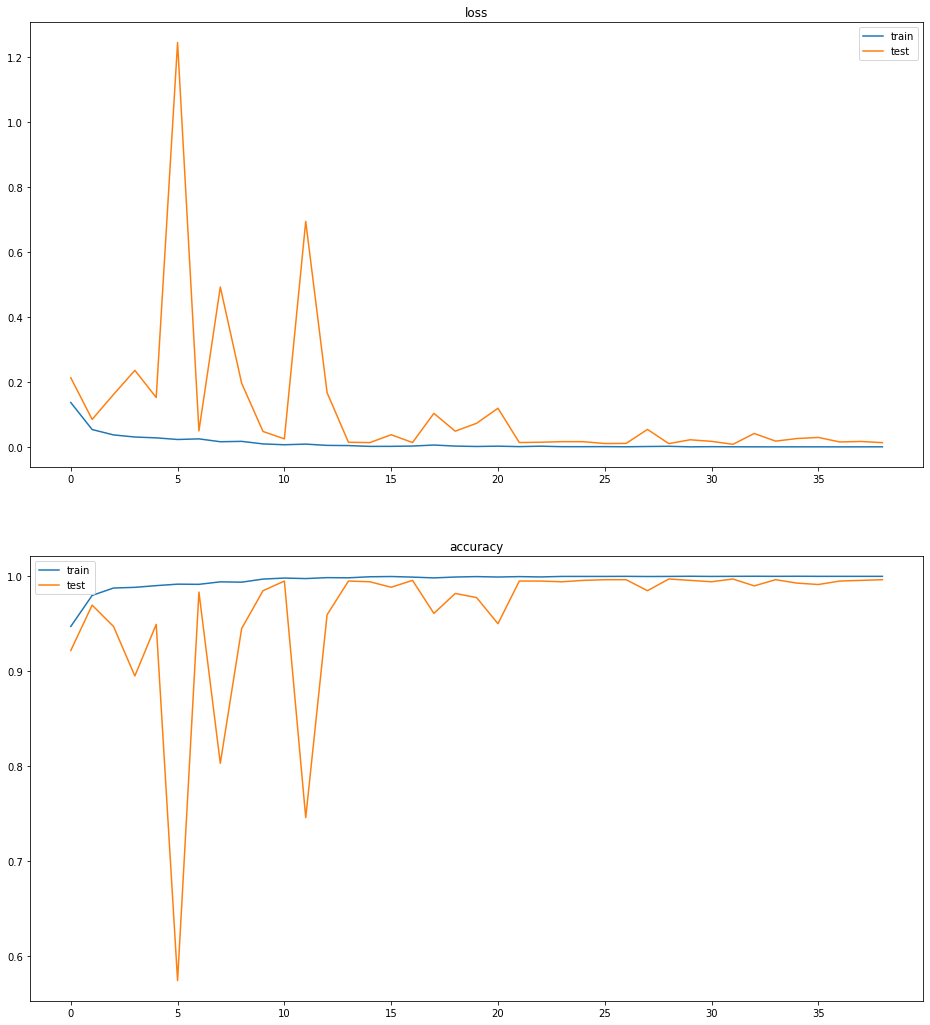

In [ ]:
plt.figure(1, figsize=(16,18))
plt.subplot(2,1,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.title('loss')
plt.subplot(2,1,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','test'])
plt.title('accuracy')
plt.show()

In [ ]:
loss, acc, pre, rec = model_1.evaluate(test_generator)
print("\ntest %s: %.2f%%" % (model_1.metrics_names[1], acc * 100))
print("\ntest %s: %.2f%%" % (model_1.metrics_names[2], pre * 100))
print("\ntest %s: %.2f%%" % (model_1.metrics_names[3], rec * 100))

44/44 [==============================] - 16s 360ms/step - loss: 0.0198 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949

test accuracy: 99.49%

test precision: 99.49%

test recall: 99.49%


Record the values above

# Model (template)

This is the template to add more models

To use the template, fill in the blanks and change the "x" variables into integers or any name you like. For example, change model_x model_2 or model _3, and so on.

In [ ]:
from tensorflow.keras.applications import DenseNet201 # insert the model name here

In [ ]:
# change x to a number (1)
base_model_x = DenseNet201(weights='imagenet', include_top=False) # insert model name here

In [ ]:
# change x to a number (5)
model_x = Sequential()
model_x.add(base_model_x) #  don't forget to change base_model_x
model_x.add(GlobalAveragePooling2D())
model_x.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [ ]:
# change x to a number (1)
model_x.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
# change x to a number (1)
model_x.summary()

In [ ]:
# change x to a number (1)
log_dir='./logs/fit'+datetime.now().strftime('%d.%m.%Y--%H-%M-%S')

model_path='/content/model_x.h5' #here

checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10,verbose=1, mode='auto')
board=TensorBoard(log_dir=log_dir,histogram_freq=1)
dec=LearningRateScheduler(scheduler)
tensorboard_callback =[checkpoint,early,board,dec]

In [ ]:
# change x to a number (1)
hist = model_x.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[tensorboard_callback]
)

In [ ]:
plt.figure(1, figsize=(16,18))
plt.subplot(2,1,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['train','test'])
plt.title('loss')
plt.subplot(2,1,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','test'])
plt.title('accuracy')
plt.show()

In [ ]:
# change x to a number (4)
loss, acc, pre, rec = model_x.evaluate(test_generator)
print("\ntest %s: %.2f%%" % (model_x.metrics_names[1], acc * 100))
print("\ntest %s: %.2f%%" % (model_x.metrics_names[2], pre * 100))
print("\ntest %s: %.2f%%" % (model_x.metrics_names[3], rec * 100))

# Training Script

You can run this in terminal using this script.

In [ ]:
from tensorflow.keras.applications import DenseNet201, ResNet50, EfficientNetB0  # Add more if needed

In [1]:
NUM_CLASSES = 1
EPOCHS = 25
LEARNING_RATE = 1e-4

def scheduler(epoch, lr):
    return lr * 0.95

def get_base_model(name='DenseNet201', input_shape=(150, 150, 3)):
    base_models = {
        'DenseNet201': DenseNet201,
        'ResNet50': ResNet50,
        'EfficientNetB0': EfficientNetB0,
        # Add more here
    }
    if name not in base_models:
        raise ValueError(f"Model '{name}' not supported.")

    return base_models[name](weights='imagenet', include_top=False, input_shape=input_shape)

def build_model(base_model_name='DenseNet201'):
    base_model = get_base_model(base_model_name)
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(NUM_CLASSES, activation='sigmoid')
    ])
    return model

def compile_and_train(model, name, train_gen, val_gen):
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    model.summary()

    log_dir = './logs/fit_' + datetime.now().strftime('%d.%m.%Y--%H-%M-%S')
    model_path = f'./model_{name}.h5'

    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1,
                                 save_best_only=True, mode='auto')
    early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
    lr_scheduler = LearningRateScheduler(scheduler)

    callbacks = [checkpoint, early_stop, tensorboard, lr_scheduler]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        steps_per_epoch=len(train_gen),
        validation_steps=len(val_gen),
        callbacks=callbacks
    )
    return history

def plot_history(history):
    plt.figure(1, figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Train', 'Val'])
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Train', 'Val'])
    plt.title('Accuracy')

    plt.show()

def evaluate_model(model, test_gen):
    loss, acc, pre, rec = model.evaluate(test_gen)
    print("\nTest Accuracy: %.2f%%" % (acc * 100))
    print("Test Precision: %.2f%%" % (pre * 100))
    print("Test Recall: %.2f%%" % (rec * 100))

In [ ]:
if __name__ == "__main__":
    base_model_choice = 'DenseNet201'  # <-- Change this only

    model = build_model(base_model_choice)
    history = compile_and_train(model, base_model_choice, train_generator, validation_generator)
    plot_history(history)
    evaluate_model(model, test_generator)

run them by:
python [python model file] --model [model name] --epochs [number of epoch]